In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import sys
import datetime
import iris
from pyhdf.SD import SD, SDC
import time
import xarray as xr

from cis import read_data, read_data_list, get_variables

In [3]:
emis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/downsampled_emis/'
save_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/ds_timecoll_emis/'

In [4]:
month='01'

In [5]:
filelist=glob.glob(emis_dir + month + ".nc")

In [6]:
da=xr.open_mfdataset(filelist)

In [7]:
da

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 351, longitude: 201, time: 744)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
  * latitude        (latitude) float64 -35.0 -34.9 -34.8 ... -0.2 -0.1 4.974e-13
  * longitude       (longitude) float64 -90.0 -89.9 -89.8 ... -70.2 -70.1 -70.0
Dimensions without coordinates: bnds
Data variables:
    SOx             (time, latitude, longitude) float32 dask.array<chunksize=(744, 351, 201), meta=np.ndarray>
    latitude_bnds   (latitude, bnds) float64 dask.array<chunksize=(351, 2), meta=np.ndarray>
    longitude_bnds  (longitude, bnds) float64 dask.array<chunksize=(201, 2), meta=np.ndarray>
Attributes:
    creation_time:  2019-11-01 15:51:43+0:00Z
    creator:        Lasse Johansson, email lasse.johansson@fmi.fi
    history:        model version: STEAM 3.3.0 (JAVA, edited 31.1.2017)
    info:           emission values describe emissions released at stack heig...
    institution:    Finnish Meteorological Institute
    references:     Jalkanen, J.-P. ,Johansson, L., et al. 2012. Extension of...
    title:          modelled shipping exhaust emissions and statistics in Wor...
    Conventions:    CF-1.7

In [8]:
da['SOx']=xr.where(da['SOx']<0, 0, da['SOx'])
da['SOx']=xr.where(da['SOx']>10, 0, da['SOx'])

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


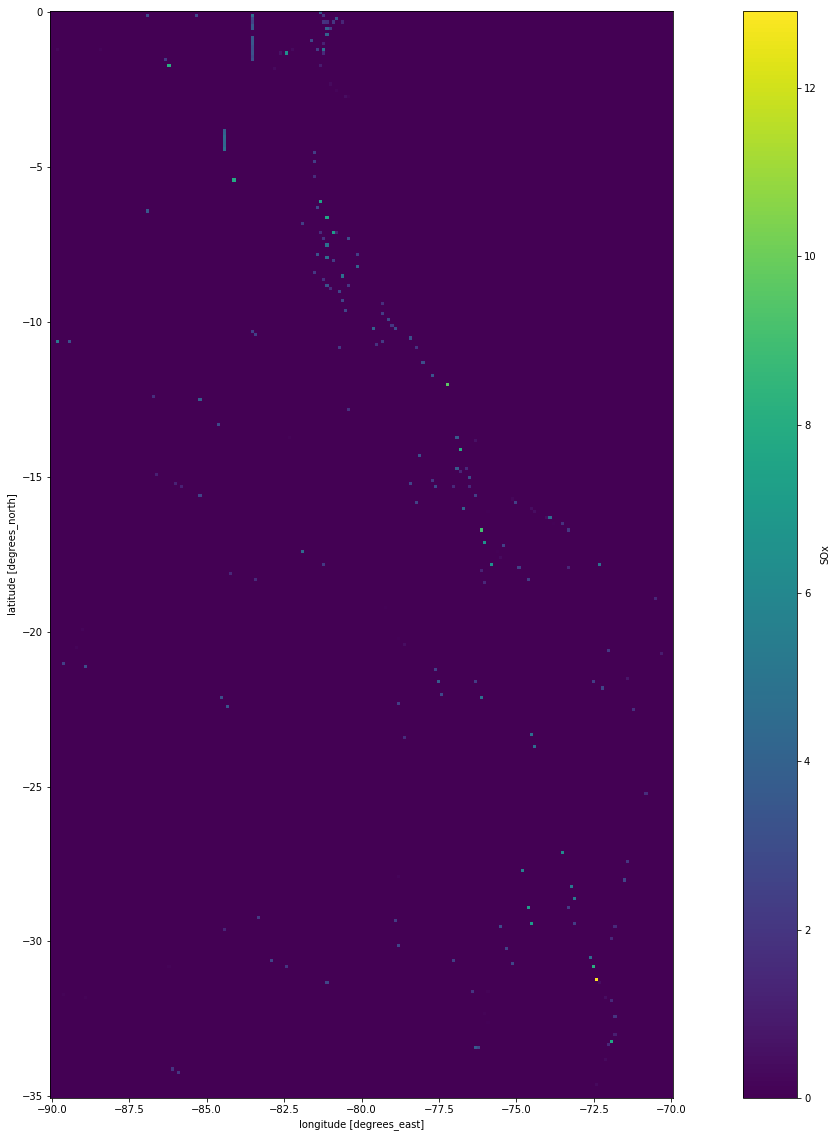

In [9]:
plt.figure(figsize=(25,20))

da['SOx'].sel(time=slice('2018-01-03T18:00:00.000000000','2018-01-04T00:00:00.000000000')).sum('time').plot(cmap='viridis', )
plt.axes().set_aspect('equal')



In [10]:
# def pop_history_callback(cube, field, filename):
#     cube.attributes.pop("history")
#     return cube

# dati=iris.load('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis/*.nc',
#                   ['Cloud_Top_Temperature',
#                 'Cloud_Effective_Radius'])
#collocate instead of merge

In [11]:
dat=xr.open_mfdataset('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis/*.nc')

In [12]:
re=dat['Cloud_Effective_Radius']

In [13]:
re=xr.where(re>1000, np.nan, re)

In [14]:
emis=da['SOx'].resample(time='24H').reduce(np.sum)

In [15]:
emis_coarsened=emis.rolling(latitude=3, longitude=3, min_periods=1, center=True).reduce(np.mean)

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


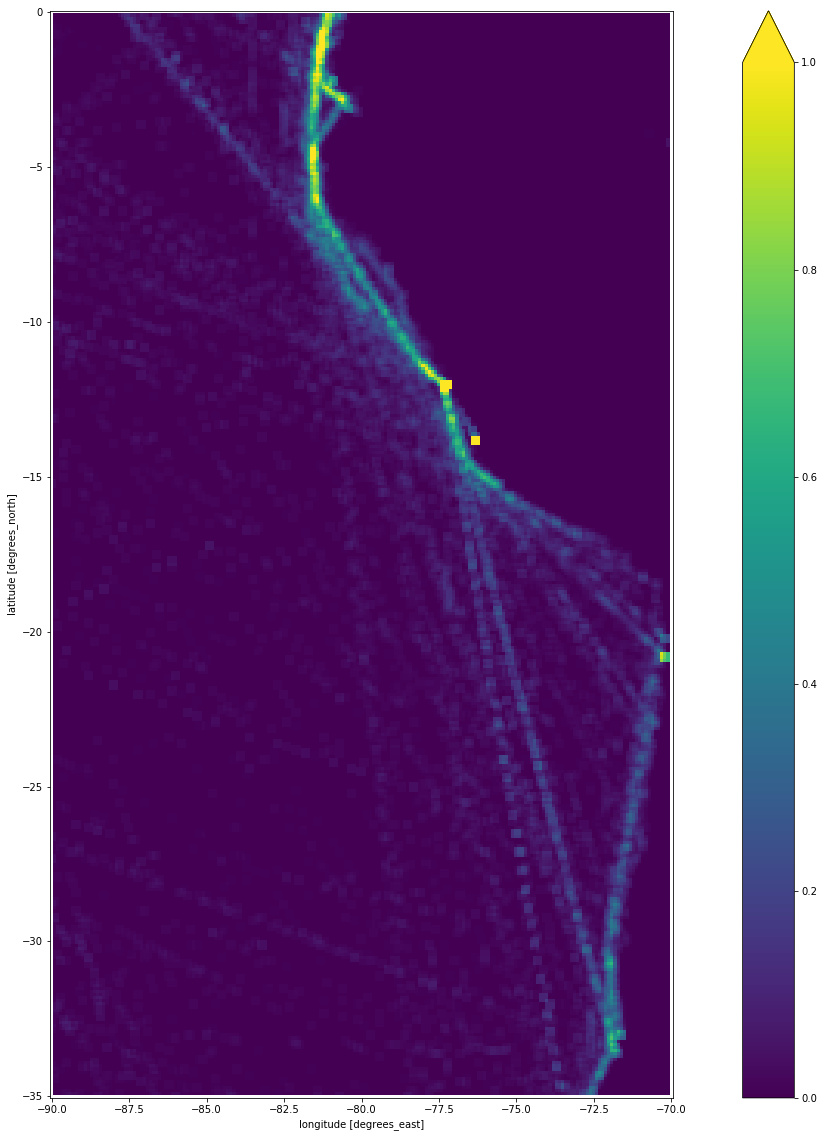

In [58]:
plt.figure(figsize=(25,20))
emis_coarsened.mean('time').plot(vmax=1)
plt.axes().set_aspect('equal')

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


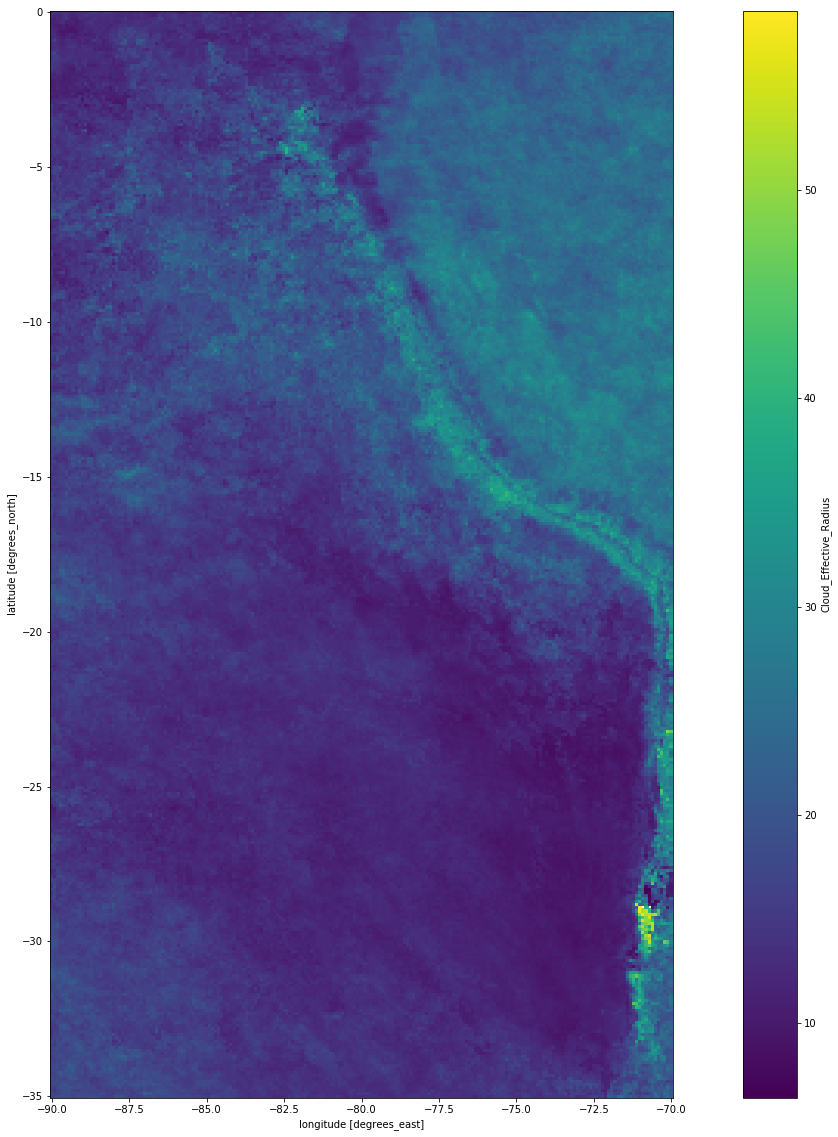

In [55]:
plt.figure(figsize=(25,20))
re.mean('time').plot()
plt.axes().set_aspect('equal')

In [19]:

emis_plus_cloud=xr.merge([re._to_temp_dataset(), emis_coarsened._to_temp_dataset()])

In [20]:
# emis_plus_cloud.plot.scatter(x='SOx', y='Cloud_Effective_Radius')

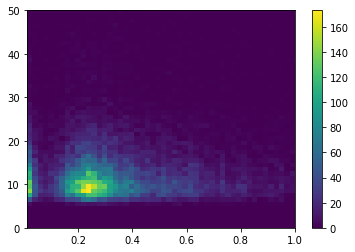

In [63]:
plt.hist2d(emis_coarsened.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18)).values.flatten(),re.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18)).values.flatten(), bins=50,range=[[0.01, 1], [0, 50]])
plt.colorbar()

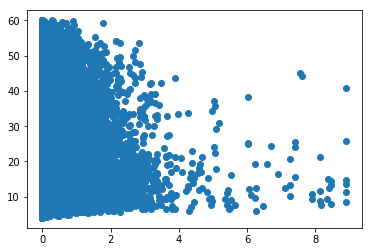

In [72]:
plt.scatter(emis_coarsened.values.flatten(),re.values.flatten())

In [70]:
# returns the effect of pollution on the size of 
def re_diff_emis(threshold, re, emis):
    
    prist=np.where(emis > threshold, np.nan, re.transpose('time', 'latitude', 'longitude'))
    #prist=np.where(emis == 0., np.nan, prist)
    re_prist=np.nanmean(prist)
    pristpoints=np.nansum(prist)/re_prist
    
    poll=np.where(emis <= threshold, np.nan, re.transpose('time', 'latitude', 'longitude'))
    re_poll=np.nanmean(poll)
    pollpoints=np.nansum(poll)/re_poll
    
    return re_prist,re_poll, pollpoints, pristpoints

In [71]:
for threshold in np.linspace(0,1,20):
    print(threshold)
    print(re_diff_emis(threshold, re.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18)), emis_coarsened.sel(longitude=slice(-90,-72.5),latitude=slice(-35,-18))))

0.0
(12.997931052506178, 12.657568969193257, 55398.0, 556301.0)
0.05263157894736842
(12.97064142218636, 12.893782848419189, 28134.0, 583565.0)
0.10526315789473684
(12.969648440906797, 12.913279636896018, 27585.0, 584114.0)
0.15789473684210525
(12.967715881490205, 12.953490559194996, 26206.0, 585493.0)
0.21052631578947367
(12.962402970850585, 13.084237115643058, 23615.0, 588084.0)
0.2631578947368421
(12.958675537547682, 13.221555573903515, 19618.0, 592081.0)
0.3157894736842105
(12.957063800035156, 13.326239207360942, 16640.0, 595059.0)
0.3684210526315789
(12.955808577950132, 13.434336266088023, 14442.0, 597257.0)
0.42105263157894735
(12.954267918343692, 13.57186125057769, 12716.0, 598983.0)
0.47368421052631576
(12.952645080582988, 13.712807068042869, 11637.0, 600062.0)
0.5263157894736842
(12.951277552455819, 13.857710864188817, 10682.0, 601017.0)
0.5789473684210527
(12.949617230581701, 14.046299738629838, 9755.0, 601944.0)
0.631578947368421
(12.948051185940242, 14.245189602048262, 8986.

154654.34801019062

In [224]:
re

<xarray.DataArray 'Cloud_Effective_Radius' (latitude: 351, longitude: 201, time: 31)>
dask.array<where, shape=(351, 201, 31), dtype=float64, chunksize=(351, 201, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -35.0 -34.9 -34.8 ... -0.2 -0.1 4.974e-13
  * longitude  (longitude) float64 -90.0 -89.9 -89.8 -89.7 ... -70.2 -70.1 -70.0
  * time       (time) datetime64[ns] 2018-01-01T19:25:10.736481 ... 2018-01-3...

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00013392, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [ ]:
#different time-windows
#coarser resolution
#spreading with time
#discounting with time